In [1]:
%run 00-start-eva-server.ipynb
cursor = connect_to_server()

nohup eva_server >> eva.log 2>&1 &
('Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /Users/jiashenc/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth\n', "05-04-2023 18:14:05 ERROR [create_udf_executor:create_udf_executor.py:handle_generic_udf:0063] Error creating UDF: Couldn't load UDF from /Users/jiashenc/Workspace/eva/eva/udfs/sift_feature_extractor.py : No module named 'kornia'. Ensure that the file exists and that it is a valid Python file.\n", "05-04-2023 18:14:05 ERROR [plan_executor:plan_executor.py:execute_plan:0175] Error creating UDF: Couldn't load UDF from /Users/jiashenc/Workspace/eva/eva/udfs/sift_feature_extractor.py : No module named 'kornia'. Ensure that the file exists and that it is a valid Python file.\n")
('Traceback (most recent call last):\n', '  File "/Users/jiashenc/Workspace/eva/eva/utils/generic_utils.py", line 73, in load_udf_class_from_file\n', '    spec.loader.exec_module(module)\n')
(' 

You should consider upgrading via the '/Users/jiashenc/Workspace/eva/evadb_venv/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Load all images
cursor.execute("LOAD IMAGE 'reddit-images/*.jpg' INTO reddit_dataset")
response = cursor.fetch_all()
print(response)
cursor.execute("LOAD IMAGE 'reddit-images/*.png' INTO reddit_dataset")
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.FAIL
@batch: 
 None
@error: Load IMAGE failed: encountered unexpected error Duplicate File: reddit-images/g348_d7jhhs3.jpg already exists in the table reddit_dataset
@status: ResponseStatus.FAIL
@batch: 
 None
@error: Load IMAGE failed: encountered unexpected error Duplicate File: reddit-images/g1190_cln9xzr.png already exists in the table reddit_dataset


In [3]:
# Keep track of which image gets the most votes
from collections import Counter
vote = Counter()

In [4]:
"""
Image-level similarity search pipeline. This pipeline creates one vector per image.
Next, we should breakdown steps how we build the index and search similar vectors 
using the index.
"""

'\nImage-level similarity search pipeline. This pipeline creates one vector per image.\nNext, we should breakdown steps how we build the index and search similar vectors \nusing the index.\n'

In [5]:
#1. Create index for the entire image
cursor.execute("""CREATE INDEX reddit_sift_image_index 
                    ON reddit_dataset (SiftFeatureExtractor(data)) 
                    USING HNSW""")
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.FAIL
@batch: 
 None
@error: Index reddit_sift_image_index already exists.


In [6]:
#2. Search similar vectors
cursor.execute("""SELECT name FROM reddit_dataset ORDER BY
                    Similarity(
                      SiftFeatureExtractor(Open('reddit-images/search.jpg')),
                      SiftFeatureExtractor(data)
                    )
                    LIMIT 5""")
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                reddit_dataset.name
0         reddit-images/search.jpg
1  reddit-images/g1190_cln97xm.jpg
2  reddit-images/g1190_clndsnu.png
3  reddit-images/g1190_clnc4uy.png
4  reddit-images/g1190_clncot0.jpg
@query_time: 0.3092507090000254


In [7]:
#3. Update votes
res_df = response.as_df()
for i in range(len(res_df)):
    vote[res_df["reddit_dataset.name"][i]] += 1
print(vote)

Counter({'reddit-images/search.jpg': 1, 'reddit-images/g1190_cln97xm.jpg': 1, 'reddit-images/g1190_clndsnu.png': 1, 'reddit-images/g1190_clnc4uy.png': 1, 'reddit-images/g1190_clncot0.jpg': 1})


In [8]:
"""
Object-level similarity search pipeline. This pipeline detects existing object per
image and then create a vector only from the cropped object. Index is then built on
top of vectors for objects. 

Note: The current support for object-level similarity search pipeline is lacking. We
are actively working on it to improve it.
"""

'\nObject-level similarity search pipeline. This pipeline detects existing object per\nimage and then create a vector only from the cropped object. Index is then built on\ntop of vectors for objects. \n\nNote: The current support for object-level similarity search pipeline is lacking. We\nare actively working on it to improve it.\n'

In [9]:
#1. Create a secondary table that contains object
cursor.execute("""CREATE MATERIALIZED VIEW reddit_object_dataset (name, data, bboxes, labels)
                    AS SELECT name, data, bboxes, labels FROM reddit_dataset
                      JOIN LATERAL UNNEST(YoloV5(data)) AS Obj(labels, bboxes, scores)""")
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.FAIL
@batch: 
 None
@error: Table: reddit_object_dataset already exists


In [10]:
#2. Create index from objects
cursor.execute("""CREATE INDEX reddit_sift_object_index
                    ON reddit_object_dataset (SiftFeatureExtractor(Crop(data, bboxes)))
                    USING HNSW""")
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.FAIL
@batch: 
 None
@error: Index reddit_sift_object_index already exists.


In [11]:
#3. Create a cropped images (We are actively working on features to allow
# us to not do this outside SQL)
cursor.execute("LOAD IMAGE 'reddit-images/search.jpg' INTO reddit_search_image_dataset")
response = cursor.fetch_all()
print(response)
cursor.execute("SELECT YoloV5(data).bboxes FROM reddit_search_image_dataset")
response = cursor.fetch_all()
print(response)


import cv2
import pathlib

res_df = response.as_df()
bboxes = res_df["yolov5.bboxes"][0]

img = cv2.imread("../reddit-images/search.jpg")
pathlib.Path("../reddit-images/search-object/").mkdir(parents=True, exist_ok=True)
for i, bbox in enumerate(bboxes):
    xmin, ymin, xmax, ymax = bbox
    xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
    cropped_img = img[ymin:ymax, xmin:xmax]
    cv2.imwrite(f"../reddit-images/search-object/search-{i}.jpg", cropped_img)

@status: ResponseStatus.FAIL
@batch: 
 None
@error: Load IMAGE failed: encountered unexpected error Duplicate File: reddit-images/search.jpg already exists in the table reddit_search_image_dataset
@status: ResponseStatus.SUCCESS
@batch: 
                                                                                          yolov5.bboxes
0  0     [254.5550079345703, 252.1867218017578, 450.48138427734375, 938.5394897460938]
1      [462....
@query_time: 0.41264875000001666


In [12]:
#4. Search on the secondary table for object-level similarity search
import os

for path in os.listdir("../reddit-images/search-object/"):
    path = "reddit-images/search-object/" + path
    cursor.execute(f"""SELECT name FROM reddit_object_dataset ORDER BY
                        Similarity(
                          SiftFeatureExtractor(Open('{path}')),
                          SiftFeatureExtractor(data)
                        )
                        LIMIT 1""")
    response = cursor.fetch_all()
    print(response)
    
    res_df = response.as_df()
    for i in range(len(res_df)):
        vote[res_df["reddit_object_dataset.name"][i]] += 1
    print(vote)

@status: ResponseStatus.SUCCESS
@batch: 
         reddit_object_dataset.name
0  reddit-images/g1074_d4npo8a.jpg
@query_time: 0.549681875000033
Counter({'reddit-images/search.jpg': 1, 'reddit-images/g1190_cln97xm.jpg': 1, 'reddit-images/g1190_clndsnu.png': 1, 'reddit-images/g1190_clnc4uy.png': 1, 'reddit-images/g1190_clncot0.jpg': 1, 'reddit-images/g1074_d4npo8a.jpg': 1})
@status: ResponseStatus.SUCCESS
@batch: 
        reddit_object_dataset.name
0  reddit-images/g348_d7jghfb.jpg
@query_time: 0.5106116670001484
Counter({'reddit-images/search.jpg': 1, 'reddit-images/g1190_cln97xm.jpg': 1, 'reddit-images/g1190_clndsnu.png': 1, 'reddit-images/g1190_clnc4uy.png': 1, 'reddit-images/g1190_clncot0.jpg': 1, 'reddit-images/g1074_d4npo8a.jpg': 1, 'reddit-images/g348_d7jghfb.jpg': 1})
@status: ResponseStatus.SUCCESS
@batch: 
         reddit_object_dataset.name
0  reddit-images/g1190_cln9xzr.png
@query_time: 0.5210122089999913
Counter({'reddit-images/search.jpg': 1, 'reddit-images/g1190_cln97xm.jpg

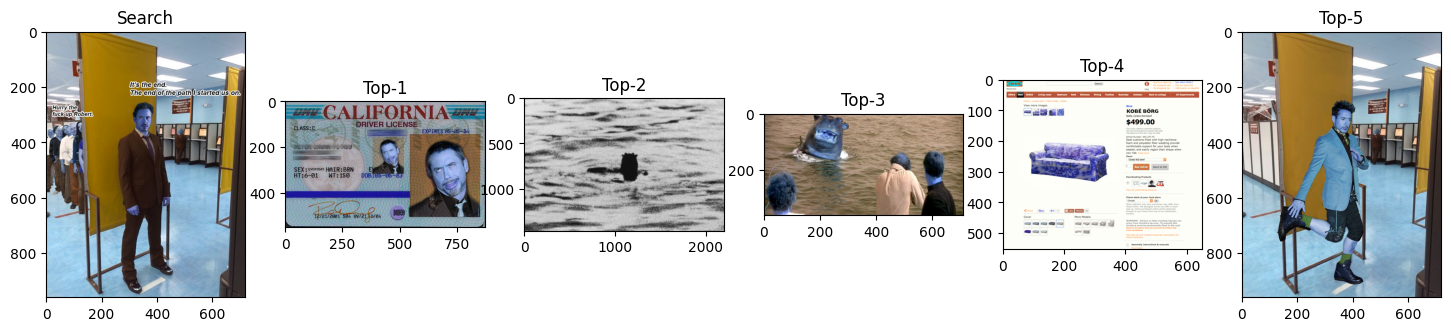

In [13]:
# !pip install matplotlib
import matplotlib.pyplot as plt

# Display top images
vote_list = list(reversed(sorted([(path, count) for path, count in vote.items()], key=lambda x: x[1])))
img_list = [path for path, _ in vote_list]

fig, ax = plt.subplots(nrows=1, ncols=6, figsize=[18,10])
ax[0].imshow(cv2.imread("../reddit-images/search.jpg"))
ax[0].set_title("Search")

for i in range(5):
    axi = ax[i + 1]
    img = cv2.imread("../" + img_list[i])
    axi.imshow(img)
    axi.set_title(f"Top-{i + 1}")

plt.show()